# 1.0 Data Ingestion

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
df = df.drop(columns=['hour', 'day', 'month', 'year'])
df

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
0,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
1,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
3,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
4,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
219187,2025-01-01 19:00:00,9.8,77,5.8,0.0,0,0,0.00,0.28,3.0,5.8,6.1
219188,2025-01-01 20:00:00,10.6,67,4.7,0.0,0,0,0.00,0.43,2.8,6.2,6.1
219189,2025-01-01 21:00:00,11.1,59,3.3,0.0,0,0,0.00,0.54,3.5,5.8,6.1
219190,2025-01-01 22:00:00,10.5,54,1.5,0.0,0,0,0.02,0.59,5.8,10.7,11.2


# 2.0 Data Preprocessing

## 2.1 Outlier Detection

In [3]:
from scipy.stats import zscore

def detect_outliers(dataframe, target_columns):
    """
    Detects outliers in the specified columns of a dataframe using three methods:
    1. Percentile-based
    2. Standard Deviation-based
    3. Z-score-based
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_columns (list): List of columns to check for outliers.
        
    Returns:
        pd.DataFrame: A dataframe containing all detected outliers (with duplicates removed).
    """
    outliers_df = pd.DataFrame()

    # Method 1: Outliers based on Percentiles
    percentiles = dataframe[target_columns].quantile([0.001, 0.999])
    for col in target_columns:
        lower_limit, upper_limit = percentiles.loc[0.001, col], percentiles.loc[0.999, col]
        percentile_outliers = dataframe[(dataframe[col] < lower_limit) | (dataframe[col] > upper_limit)]
        outliers_df = pd.concat([outliers_df, percentile_outliers])
    
    print(f'Outliers based on Percentiles: {percentile_outliers.shape[0]}')

    # Method 2: Outliers based on Standard Deviation
    for col in target_columns:
        mean, std_dev = dataframe[col].mean(), dataframe[col].std()
        max_limit, min_limit = mean + 3 * std_dev, mean - 3 * std_dev
        std_dev_outliers = dataframe[(dataframe[col] < min_limit) | (dataframe[col] > max_limit)]
        outliers_df = pd.concat([outliers_df, std_dev_outliers])
    
    print(f'Outliers based on Standard Deviation: {std_dev_outliers.shape[0]}')

    # Method 3: Outliers based on Z-score
    for col in target_columns:
        z_scores = zscore(dataframe[col])
        z_score_outliers = dataframe[(z_scores < -3) | (z_scores > 3)]
        outliers_df = pd.concat([outliers_df, z_score_outliers])
    
    print(f'Outliers based on Z-score: {z_score_outliers.shape[0]}')

    # Remove duplicates to avoid counting the same outlier multiple times across methods
    outliers_df = outliers_df.drop_duplicates()
    
    return outliers_df

In [4]:
target_columns = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m'
]
outliers = detect_outliers(df, target_columns)
print(f'Total unique outliers detected: {outliers.shape[0]}')

Outliers based on Percentiles: 385
Outliers based on Standard Deviation: 2658
Outliers based on Z-score: 2658
Total unique outliers detected: 24961


In [5]:
outliers_df = detect_outliers(df, ['rain'])
print(f'Total unique outliers detected: {outliers_df.shape[0]}')

Outliers based on Percentiles: 217
Outliers based on Standard Deviation: 3106
Outliers based on Z-score: 3106
Total unique outliers detected: 3106


In [6]:
print(outliers_df.rain.unique().shape[0])

182


## 2.2 For rain w.r.t. time only (1 variable)

### 2.2.1 Date-time transformation

In [7]:
df.index = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
df

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
time,,,,,,,,,,,,
2000-01-01 00:00:00,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
2000-01-01 01:00:00,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2000-01-01 02:00:00,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
2000-01-01 03:00:00,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
2000-01-01 04:00:00,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,2025-01-01 19:00:00,9.8,77,5.8,0.0,0,0,0.00,0.28,3.0,5.8,6.1
2025-01-01 20:00:00,2025-01-01 20:00:00,10.6,67,4.7,0.0,0,0,0.00,0.43,2.8,6.2,6.1
2025-01-01 21:00:00,2025-01-01 21:00:00,11.1,59,3.3,0.0,0,0,0.00,0.54,3.5,5.8,6.1


### 2.2.2 Yearly Rainfall Plot

<Axes: xlabel='time'>

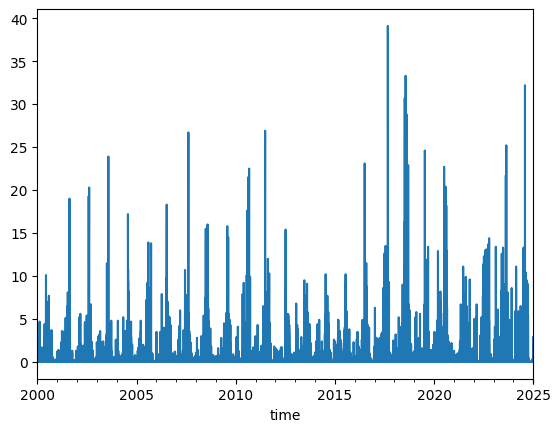

In [8]:
rain = df['rain']
rain.plot()

### 2.2.3 Batch Training

In [9]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        
        label = df_as_np[i+window_size]
        y.append(label)
    
    return np.array(X), np.array(y)

In [10]:
WINDOW_SIZE = 5

X1, y1 = df_to_X_y(rain, WINDOW_SIZE)
X1.shape, y1.shape

((219187, 5, 1), (219187,))

### 2.2.4 Train Test Val Split

In [11]:
X_train1, y_train1 = X1[:200000], y1[:200000]
X_val1, y_val1 = X1[200000:210000], y1[200000:210000]
X_test1, y_test1 = X1[210000:], y1[210000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200000, 5, 1), (200000,), (10000, 5, 1), (10000,), (9187, 5, 1), (9187,))

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

### 2.2.5 LSTM Model

In [13]:
model_lstm = Sequential([
    InputLayer((5, 1)),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,985 (117.13 KB)

 Trainable params: 29,985 (117.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# cp1 = ModelCheckpoint('../artifacts/models/single_variable/model_1.keras', save_best_only=True)

# model_1.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss=MeanSquaredError(), 
#     metrics=[RootMeanSquaredError()]
# )

# model_1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=2, callbacks=[cp1])

In [14]:
def train_model(model, checkpoint_path, X_train, y_train, X_val, y_val, epochs=2, learning_rate=0.0001):
    """
    Function to compile and train a model with specified parameters.
    
    Args:
    - model: The Keras model to be trained.
    - checkpoint_path: File path to save the best model during training.
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - epochs: Number of epochs for training (default: 2).
    - learning_rate: Learning rate for the optimizer (default: 0.0001).
    
    Returns:
    - history: Training history object.
    """
    # Define the model checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=[
            'root_mean_squared_error',
            'accuracy'
        ]
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=[checkpoint]
    )

    return history

In [15]:
history_1 = train_model(
    model=model_lstm,
    checkpoint_path='../artifacts/models/single_variable/model_lstm.keras',
    X_train=X_train1,
    y_train=y_train1,
    X_val=X_val1,
    y_val=y_val1,
    epochs=2
)

Epoch 1/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.8287 - loss: 0.3885 - root_mean_squared_error: 0.6220 - val_accuracy: 0.8693 - val_loss: 0.3472 - val_root_mean_squared_error: 0.5892
Epoch 2/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.8244 - loss: 0.2603 - root_mean_squared_error: 0.5097 - val_accuracy: 0.8707 - val_loss: 0.3222 - val_root_mean_squared_error: 0.5676


In [16]:
model_lstm = load_model('../artifacts/models/single_variable/model_lstm.keras')

#### 2.2.5.1 Train v/s Actual

In [ ]:
# train_predictions = model_1.predict(X_train1).flatten()

# train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actual Predictions': y_train1})
# train_results

In [ ]:
# plt.plot(train_results['Train Predictions'][50:500], label='Train Predictions', color='blue', linestyle='-')
# plt.plot(train_results['Actual Predictions'][50:500], label='Actual Predictions', color='orange', linestyle='--')

# plt.xlabel('Time Stamps', fontsize=12)
# plt.ylabel('Rainfall (mm)', fontsize=12)
# plt.title('Train Predictions vs Actual Predictions', fontsize=14)

In [17]:
def plot_predictions(model, X_data, y_data, label, start=50, end=500, ylabel='Rainfall (mm)', title_suffix=''):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    print(results_df)

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return results_df

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step
        Train Predictions  Actual Values
0                0.023523            0.0
1                0.023523            0.0
2                0.023523            0.0
3                0.023523            0.0
4                0.023523            0.0
...                   ...            ...
199995           0.023523            0.0
199996           0.023523            0.0
199997           0.023523            0.0
199998           0.023523            0.0
199999           0.023523            0.0

[200000 rows x 2 columns]


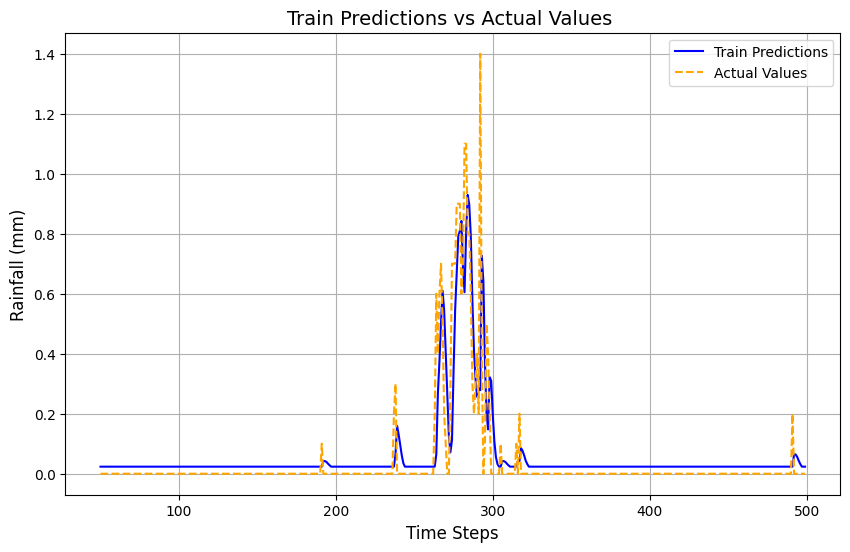

In [18]:
train_results = plot_predictions(
    model=model_lstm, 
    X_data=X_train1, 
    y_data=y_train1, 
    label='Train', 
    start=50, 
    end=500
)

#### 2.2.5.2 Val v/s Actual

In [ ]:
# val_predictions = model_1.predict(X_val1).flatten()
# val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actual Predictions': y_val1})
# val_results

In [ ]:
# plt.plot(val_results['Val Predictions'][:500], label='Val Predictions', color='blue', linestyle='-')
# plt.plot(val_results['Actual Predictions'][:500], label='Actual Predictions', color='orange', linestyle='--')

# plt.xlabel('Time Stamps', fontsize=12)
# plt.ylabel('Rainfall (mm)', fontsize=12)
# plt.title('Val Predictions vs Actual Predictions', fontsize=14)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      Val Predictions  Actual Values
0            0.023523            0.0
1            0.023523            0.0
2            0.023523            0.0
3            0.023523            0.0
4            0.023523            0.0
...               ...            ...
9995         0.023523            0.0
9996         0.023523            0.0
9997         0.023523            0.0
9998         0.023523            0.0
9999         0.023523            0.0

[10000 rows x 2 columns]


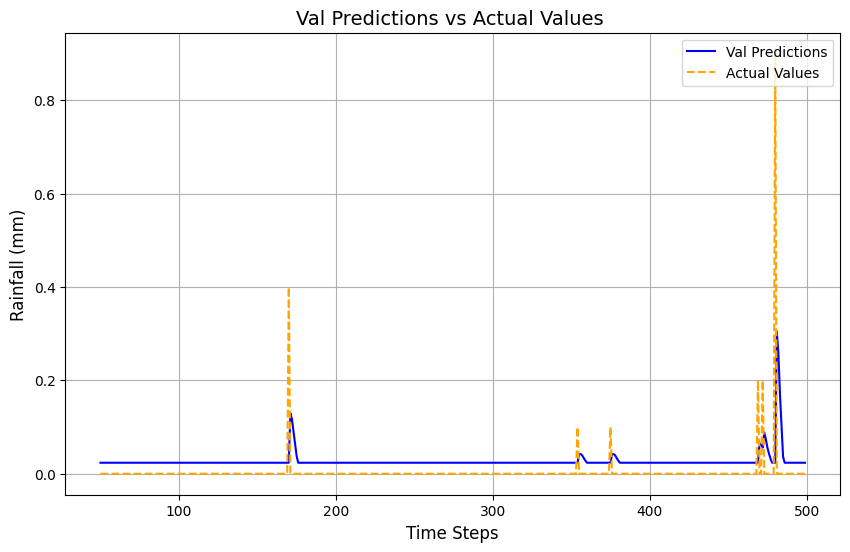

In [19]:
val_results = plot_predictions(
    model=model_lstm, 
    X_data=X_val1, 
    y_data=y_val1, 
    label='Val', 
    start=50, 
    end=500
)

#### 2.2.5.3 Test v/s Actual

In [ ]:
# test_predictions = model_1.predict(X_test1).flatten()
# test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actual Predictions':y_test1})
# test_results

In [ ]:
# plt.plot(test_results['Test Predictions'][:500], label='Test Predictions', color='blue', linestyle='-')
# plt.plot(test_results['Actual Predictions'][:500], label='Actual Predictions', color='orange', linestyle='--')

# plt.xlabel('Time Stamps', fontsize=12)
# plt.ylabel('Rainfall (mm)', fontsize=12)
# plt.title('Test Predictions vs Actual Predictions', fontsize=14)

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
      Test Predictions  Actual Values
0             0.023523            0.0
1             0.023523            0.0
2             0.023523            0.0
3             0.023523            0.0
4             0.023523            0.0
...                ...            ...
9182          0.023523            0.0
9183          0.023523            0.0
9184          0.023523            0.0
9185          0.023523            0.0
9186          0.023523            0.0

[9187 rows x 2 columns]


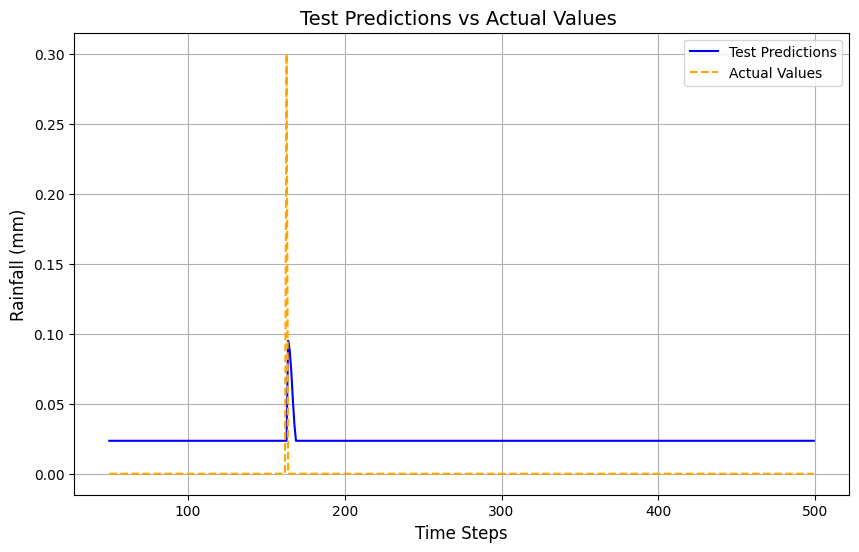

In [20]:
test_results = plot_predictions(
    model=model_lstm, 
    X_data=X_test1, 
    y_data=y_test1, 
    label='Test', 
    start=50, 
    end=500
)

### 2.2.6 GRU Model

In [21]:
model_gru = Sequential([
    InputLayer((5, 1)),
    GRU(64, activation='relu', return_sequences=True),
    GRU(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,945 (89.63 KB)

 Trainable params: 22,945 (89.63 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history_2 = train_model(
    model=model_gru,
    checkpoint_path='../artifacts/models/single_variable/model_gru.keras',
    X_train=X_train1,
    y_train=y_train1,
    X_val=X_val1,
    y_val=y_val1,
    epochs=2
)

Epoch 1/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.8279 - loss: 0.3854 - root_mean_squared_error: 0.6168 - val_accuracy: 0.8723 - val_loss: 0.3367 - val_root_mean_squared_error: 0.5803
Epoch 2/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.8291 - loss: 0.2340 - root_mean_squared_error: 0.4832 - val_accuracy: 0.8727 - val_loss: 0.3288 - val_root_mean_squared_error: 0.5734


In [23]:
model_gru = load_model('../artifacts/models/single_variable/model_gru.keras')

#### 2.2.6.1 Train v/s Actual

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
        Train Predictions  Actual Values
0                 0.02656            0.0
1                 0.02656            0.0
2                 0.02656            0.0
3                 0.02656            0.0
4                 0.02656            0.0
...                   ...            ...
199995            0.02656            0.0
199996            0.02656            0.0
199997            0.02656            0.0
199998            0.02656            0.0
199999            0.02656            0.0

[200000 rows x 2 columns]


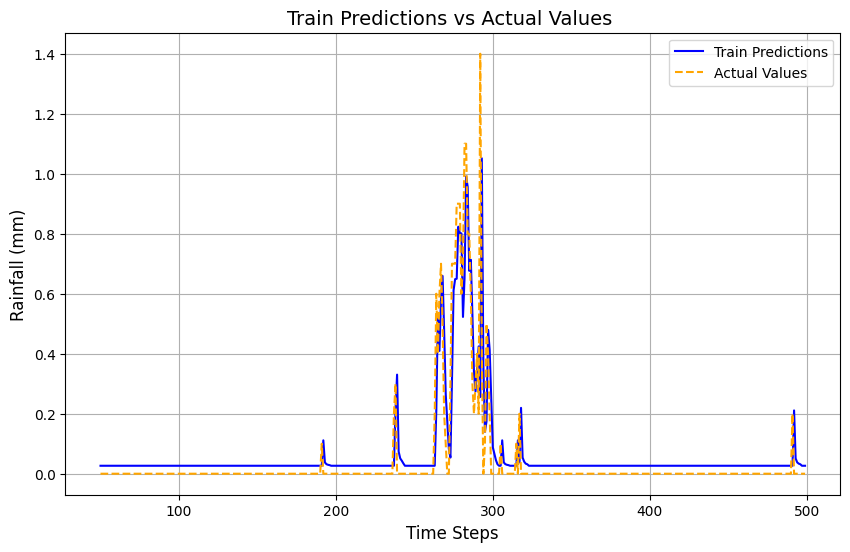

In [24]:
train_results = plot_predictions(
    model=model_gru, 
    X_data=X_train1, 
    y_data=y_train1, 
    label='Train', 
    start=50, 
    end=500
)

#### 2.2.6.2 Val v/s Actual

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      Val Predictions  Actual Values
0             0.02656            0.0
1             0.02656            0.0
2             0.02656            0.0
3             0.02656            0.0
4             0.02656            0.0
...               ...            ...
9995          0.02656            0.0
9996          0.02656            0.0
9997          0.02656            0.0
9998          0.02656            0.0
9999          0.02656            0.0

[10000 rows x 2 columns]


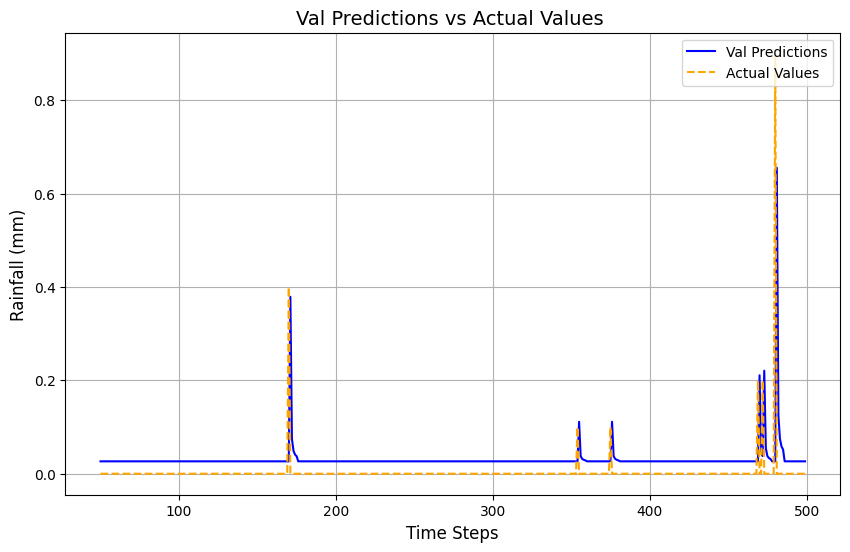

In [25]:
val_results = plot_predictions(
    model=model_gru, 
    X_data=X_val1, 
    y_data=y_val1, 
    label='Val', 
    start=50, 
    end=500
)

#### 2.2.6.3 Test v/s Actual

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      Test Predictions  Actual Values
0              0.02656            0.0
1              0.02656            0.0
2              0.02656            0.0
3              0.02656            0.0
4              0.02656            0.0
...                ...            ...
9182           0.02656            0.0
9183           0.02656            0.0
9184           0.02656            0.0
9185           0.02656            0.0
9186           0.02656            0.0

[9187 rows x 2 columns]


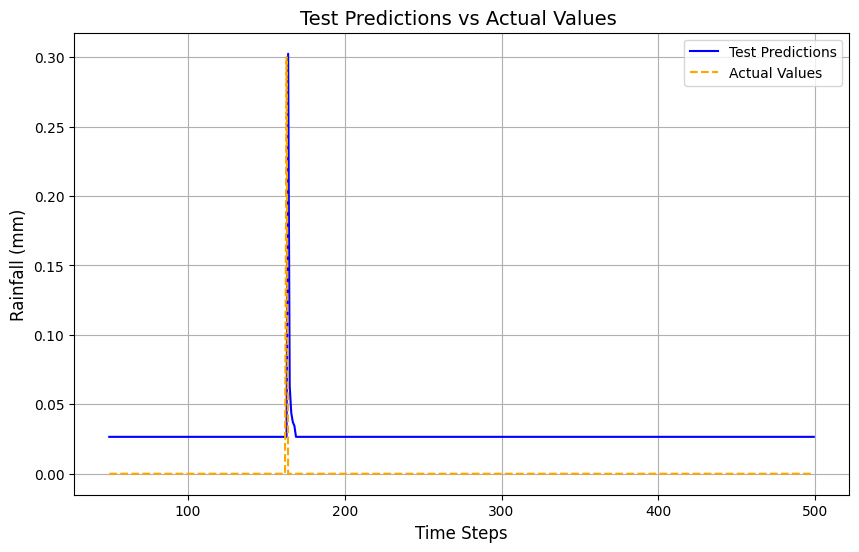

In [26]:
test_results = plot_predictions(
    model=model_gru, 
    X_data=X_test1, 
    y_data=y_test1, 
    label='Test', 
    start=50, 
    end=500
)

### 2.2.7 CNN 1D Model

In [27]:
model_cnn = Sequential([
    InputLayer((5, 1)),
    Conv1D(64, kernel_size=2, activation='relu'),
    Conv1D(32, kernel_size=2, activation='relu'),
    Flatten(),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 3, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history_3 = train_model(
    model=model_cnn,
    checkpoint_path='../artifacts/models/single_variable/model_cnn.keras',
    X_train=X_train1,
    y_train=y_train1,
    X_val=X_val1,
    y_val=y_val1,
    epochs=2
)

Epoch 1/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8261 - loss: 0.3378 - root_mean_squared_error: 0.5741 - val_accuracy: 0.8718 - val_loss: 0.3468 - val_root_mean_squared_error: 0.5889
Epoch 2/2
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.8277 - loss: 0.2190 - root_mean_squared_error: 0.4676 - val_accuracy: 0.8715 - val_loss: 0.3330 - val_root_mean_squared_error: 0.5770


In [29]:
model_cnn = load_model('../artifacts/models/single_variable/model_cnn.keras')

#### 2.2.7.1 Train v/s Actual

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
        Train Predictions  Actual Values
0                0.026069            0.0
1                0.026069            0.0
2                0.026069            0.0
3                0.026069            0.0
4                0.026069            0.0
...                   ...            ...
199995           0.026069            0.0
199996           0.026069            0.0
199997           0.026069            0.0
199998           0.026069            0.0
199999           0.026069            0.0

[200000 rows x 2 columns]


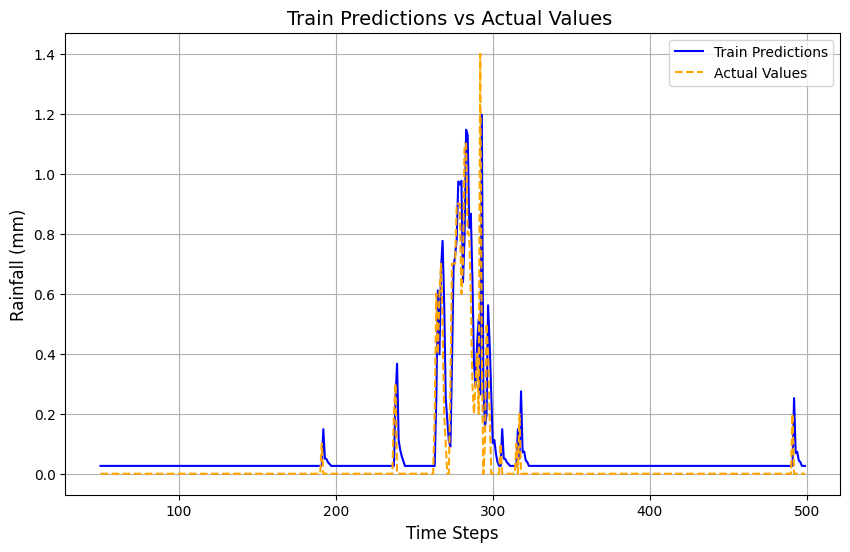

In [30]:
train_results = plot_predictions(
    model=model_cnn, 
    X_data=X_train1, 
    y_data=y_train1, 
    label='Train', 
    start=50, 
    end=500
)

#### 2.2.7.2 Val v/s Actual

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
      Val Predictions  Actual Values
0            0.026069            0.0
1            0.026069            0.0
2            0.026069            0.0
3            0.026069            0.0
4            0.026069            0.0
...               ...            ...
9995         0.026069            0.0
9996         0.026069            0.0
9997         0.026069            0.0
9998         0.026069            0.0
9999         0.026069            0.0

[10000 rows x 2 columns]


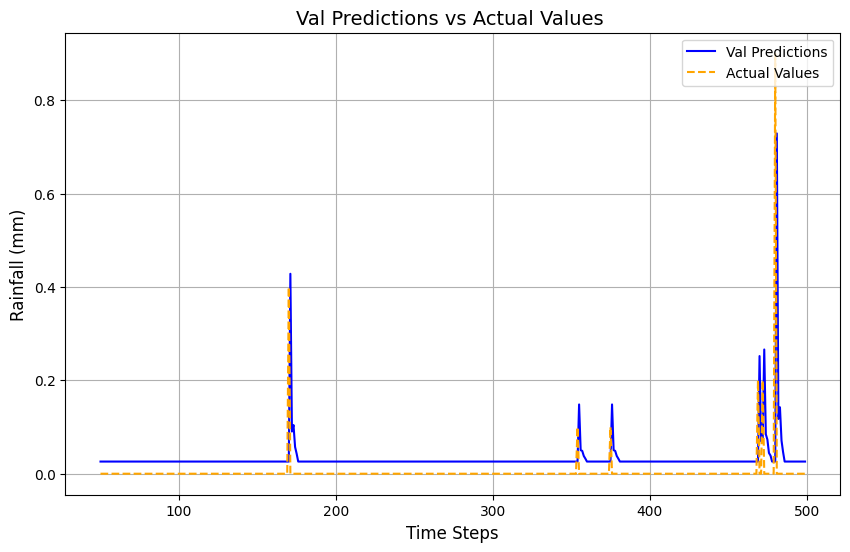

In [31]:
val_results = plot_predictions(
    model=model_cnn, 
    X_data=X_val1, 
    y_data=y_val1, 
    label='Val', 
    start=50, 
    end=500
)

#### 2.2.7.3 Test v/s Actual

288/288 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
      Test Predictions  Actual Values
0             0.026069            0.0
1             0.026069            0.0
2             0.026069            0.0
3             0.026069            0.0
4             0.026069            0.0
...                ...            ...
9182          0.026069            0.0
9183          0.026069            0.0
9184          0.026069            0.0
9185          0.026069            0.0
9186          0.026069            0.0

[9187 rows x 2 columns]


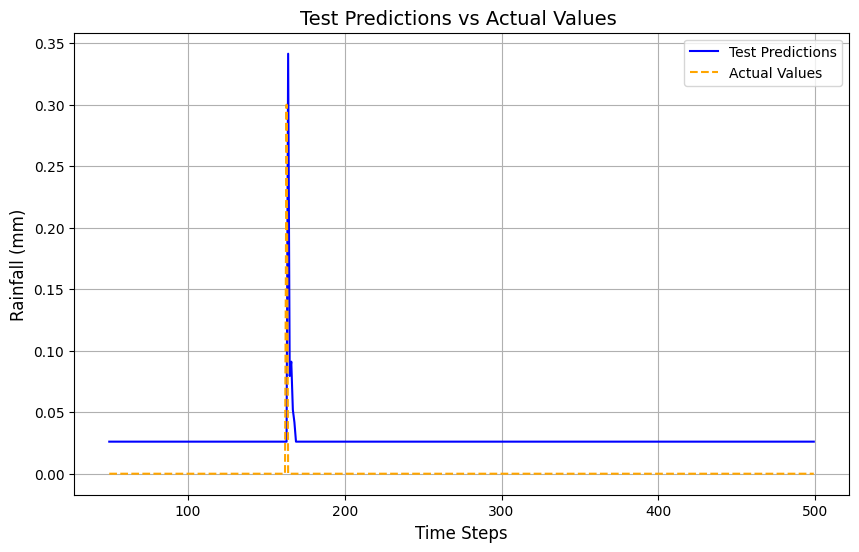

In [32]:
test_results = plot_predictions(
    model=model_cnn, 
    X_data=X_test1, 
    y_data=y_test1, 
    label='Test', 
    start=50, 
    end=500
)